In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import csv
import matplotlib.pyplot as plt 
import collections
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from tqdm import tqdm

from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

### Gridsearch
from pprint import pprint
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
#Loading Data
train = pd.read_csv("train_data_w_ingredients.csv", sep=';', error_bad_lines=False, index_col=0)
test_final = pd.read_csv("test_data_w_ingredients.csv", sep=';', error_bad_lines=False, index_col=0)

In [9]:
train.drop(["index"], axis=1, inplace=True)
train.drop(["name"], axis=1, inplace=True)
test_final.drop(["index"], axis=1, inplace=True)
test_final.drop(["name"], axis=1, inplace=True)

In [10]:
print("Document Count")
print(train.groupby('cuisine').count())

Document Count
            ingredients
cuisine                
Chinese              60
Greek                50
Iberic               40
Italian              50
Thai                 50
Vietnamese           50
french               50
korean               50


In [11]:
european = ["Italian","Iberic","french","Greek"]

def continental (row):
    if row['cuisine'] in european:
        return 'european'
    return 'asian'

train["continental"]=train.apply(lambda row: continental(row), axis=1)
train.sample(15)

,ingredients,cuisine,continental
69,"['1 tablespoon extra-virgin olive oil', '2 pou...",Greek,european
377,"['1 pound sea scallops (fresh)', '1 teaspoon s...",Iberic,european
111,"['4 pounds beef bones (meaty, cut into 2- to 3...",french,european
396,"['3 tablespoons olive oil (regular)', '12 chic...",Iberic,european
257,"['2 stalks lemongrass (fresh, tough outer laye...",Thai,asian
230,"['3 pounds boneless beef bottom round roast', ...",Italian,european
185,"['3/4 cup brown sugar (packed)', '1/2 cup tama...",korean,asian
296,"['4 tablespoons coconut milk', '1 1/2 tablespo...",Thai,asian
233,"['1 tablespoon extra virgin olive oil', '3 tab...",Italian,european
360,"['1 head broccoli (cut into florets)', '3 tabl...",Chinese,asian


In [12]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 


def preprocess(text):
    text=str(text) #stringify
    text = text.lower() #kleinschreibung
    text = re.sub("\(.*?\)","()",text) #Alternativen entfernen - also alles zwischen ( )
    text=text.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words] 
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)


# Apply to the DF series
train['cleanText']=train['ingredients'].map(lambda s:preprocess(s)) 
train.drop(["ingredients"], axis=1, inplace=True)
test_final['cleanText']=test_final['ingredients'].map(lambda s:preprocess(s)) 
test_final.drop(["ingredients"], axis=1, inplace=True)
train.head(3)

,cuisine,continental,cleanText
1,Vietnamese,asian,cup beef broth cup water yellow onion clove ga...
2,Vietnamese,asian,pound ground chicken tablespoon fish sauc onio...
3,Vietnamese,asian,pound pork blade steak tablespoon light brown ...


In [13]:
test_final.head(3)

,cuisine,cleanText
1,Greek,cup liquid ounc garbanzo bean tablespoon tahin...
2,Greek,cup instant couscou cup water cup chicken stoc...
3,Greek,onion garlic clove tablespoon oil cup long gra...


In [75]:
train["cleanText"].iloc[0]

'cup beef broth cup water yellow onion clove garlic whole star ani whole clove ginger cinnamon stick tablespoon fish sauc salt black pepper packag rice noodl ounc steak bean sprout fresh cilantro fresh ginger lime wedg green onion jalapeno thai basil'

In [62]:
d = Counter(" ".join(train["cleanText"]).split()).most_common()

all_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient','overall_count'])
all_recipes_df

,ingredient,overall_count
0,tablespoon,1059
1,cup,985
2,teaspoon,855
3,oil,361
4,sauc,327
...,...,...
647,poppi,1
648,sweeten,1
649,condens,1
650,full,1


In [63]:
d = Counter(" ".join(asian_recipes["cleanText"]).split()).most_common()

asian_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['asian_ingredient','asian_count'])
asian_recipes_df

,asian_ingredient,asian_count
0,tablespoon,715
1,cup,480
2,teaspoon,440
3,sauc,302
4,oil,210
...,...,...
401,lite,1
402,chestnut,1
403,almond,1
404,xanthan,1


In [59]:
d = Counter(" ".join(european_recipes["cleanText"]).split()).most_common()

european_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['european_ingredient','european_count'])
european_recipes_df

,european_ingredient,european_count
0,cup,505
1,teaspoon,415
2,tablespoon,344
3,salt,196
4,pepper,182
...,...,...
475,condens,1
476,full,1
477,blade,1
478,free,1


In [76]:
cuisine_names = list(train['cuisine'].value_counts().index)
cuisine_names

['Chinese',
 'french',
 'Thai',
 'Vietnamese',
 'Italian',
 'Greek',
 'korean',
 'Iberic']

In [78]:
continental_names = list(train['continental'].value_counts().index)
continental_names

['asian', 'european']

In [141]:
test = all_recipes_df

for cuisine in continental_names:
    df = train.loc[train['continental'] == cuisine]
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()

    count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
    test = pd.merge(test, count_df, on='ingredient', how='left')
    
    
for cuisine in cuisine_names:
    df = train.loc[train['cuisine'] == cuisine]
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()

    count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
    test = pd.merge(test, count_df, on='ingredient', how='left')
    

test

,ingredient,overall_count,asian,european,Chinese,french,Thai,Vietnamese,Italian,Greek,korean,Iberic
0,tablespoon,1059,715.0,344.0,191.0,126.0,199.0,134.0,76.0,96.0,191.0,46.0
1,cup,985,480.0,505.0,145.0,144.0,115.0,110.0,151.0,139.0,110.0,71.0
2,teaspoon,855,440.0,415.0,154.0,106.0,94.0,68.0,85.0,161.0,124.0,63.0
3,oil,361,210.0,151.0,76.0,34.0,38.0,27.0,32.0,50.0,69.0,35.0
4,sauc,327,302.0,25.0,89.0,2.0,80.0,78.0,17.0,2.0,55.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
647,poppi,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
648,sweeten,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
649,condens,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
650,full,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [218]:
indexList = []

remove_test = test
for cuisine in continental_names:
    indexNames = remove_test[ remove_test[cuisine] >= 2 ].index
    print(cuisine)
    print(indexNames)
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

test.drop(indexList , inplace=True)
remove_list = remove_test['ingredient'].tolist()

remove_list

KeyError: 'asian'

In [121]:
indexList = []
for cuisine in cuisine_names:
    indexNames = test[ test[cuisine] <= 2 ].index
    print(indexNames)
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

test.drop(indexList , inplace=True)
remove_list = test['ingredient'].tolist()
len(remove_list)

Int64Index([ 27,  34,  42,  56,  61,  63,  70,  74,  84,  88,  91,  95,  96,
            105, 108, 109, 117, 122, 123, 128, 130, 139, 151, 153, 154, 179,
            180, 181, 183, 186, 198, 201, 207, 214, 220, 223, 225, 242, 262,
            267, 268, 284, 287, 288, 298, 306, 332, 336, 338, 344, 351, 401,
            404, 409, 417, 418, 419, 420, 619, 620, 621, 622, 623, 624],
           dtype='int64')
Int64Index([  4,  23,  40,  66,  69,  72,  74,  78,  87,  99,
            ...
            510, 511, 512, 513, 514, 515, 516, 517, 518, 519],
           dtype='int64', length=159)
Int64Index([ 16,  27,  39,  41,  52,  56,  57,  58,  59,  62,
            ...
            609, 610, 611, 612, 613, 614, 615, 616, 617, 618],
           dtype='int64', length=131)
Int64Index([ 26,  27,  41,  50,  52,  54,  65,  70,  74,  75,
            ...
            446, 447, 448, 449, 450, 451, 452, 453, 454, 455],
           dtype='int64', length=132)
Int64Index([ 28,  31,  32,  33,  40,  45,  49,  69,  70,

71

In [155]:
train.head(5)

,cuisine,continental,cleanText
1,Vietnamese,asian,cup beef broth cup water yellow onion clove ga...
2,Vietnamese,asian,pound ground chicken tablespoon fish sauc onio...
3,Vietnamese,asian,pound pork blade steak tablespoon light brown ...
4,Vietnamese,asian,pound chicken thigh tablespoon oil clove garli...
5,Vietnamese,asian,marrow bone ounc beef stock ounc water onion g...


In [11]:
def generate_remove_list(df, min_overall_count, min_count_in_cuisine):
    
    indexList = []
    
    cuisine_names = list(df['cuisine'].value_counts().index)
    continental_names = list(df['continental'].value_counts().index)
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()
    all_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient','overall_count'])
    words_df = all_recipes_df
    
    for cuisine in continental_names:
        df = train.loc[train['continental'] == cuisine]

        d = Counter(" ".join(df["cleanText"]).split()).most_common()

        count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
        words_df = pd.merge(words_df, count_df, on='ingredient', how='left')
    
    
    for cuisine in cuisine_names:
        df = train.loc[train['cuisine'] == cuisine]

        d = Counter(" ".join(df["cleanText"]).split()).most_common()

        count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
        words_df = pd.merge(words_df, count_df, on='ingredient', how='left')
        
    
    for cuisine in continental_names:
        indexNames = []
        indexNames = words_df[ words_df[cuisine] <= min_overall_count ].index
        
        for i in indexNames:        
            if i in indexList:
                pass
            else:
                indexList.append(i)
    
    for cuisine in cuisine_names:
        indexNames = []
        indexNames = words_df[ words_df[cuisine] <= min_count_in_cuisine ].index

        for i in indexNames:        
            if i in indexList:
                pass
            else:
                indexList.append(i)




    words_df.drop(indexList , inplace=True)
    
    remove_list = words_df['ingredient'].tolist()
    

    
    
    return remove_list
    

        
        
    


In [7]:
remove_list = generate_remove_list(train, 1 , 1)
len(remove_list)

NameError: name 'generate_remove_list' is not defined

In [12]:
def remove_common_words(sentence, rem_list):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in rem_list]
    return " ".join(filtered_words)

In [ ]:
train['cleanText_removed']=train['cleanText'].map(lambda s:remove_common_words(s)) 
train.head(1)

In [174]:
rows_list = []

def test_classifier_with_remove(clf,name):
    for i in tqdm([1,2,3,5,10,100, 1000]):
        for e in tqdm([1,2,3,5,10,100, 1000]):
            test = train

            remove_list = generate_remove_list(test, i , e)
            len_remove_list = len(remove_list)

            test['cleanText_removed']=test['cleanText'].map(lambda s:remove_common_words(s))

            X = test['cleanText_removed']
            Y = test['cuisine']
            x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                                test_size=.2, 
                                                                random_state=8)


            pipeline = Pipeline([('vect', CountVectorizer()),
                                 ('clf', clf),
                                ])

            pipeline.fit(x_train, y_train)

            y_pred = pipeline.predict(x_test)
            score = accuracy_score(y_pred, y_test)

            dict1 = {
                        "Length of remove_list": len_remove_list,
                        "Accuracy": score,
                        "Removed words": remove_list,
                        "Classifier": name,
                        "Method": "auto"
                    }
            rows_list.append(dict1)

        


https://stackoverflow.com/questions/41844311/list-of-all-classification-algorithms

In [17]:
from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='classifier')

all_clfs = []
for name, ClassifierClass in estimators:
    try:
        clf = ClassifierClass()
        all_clfs.append(clf)
    except Exception as e:
        print('Unable to import', name)
        print(e)
        
names =[]
classifiers = all_clfs

for classifier in all_clfs: 
    
    string = str(classifier).strip("()")
    names.append(string)

Unable to import ClassifierChain
__init__() missing 1 required positional argument: 'base_estimator'
Unable to import MultiOutputClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import OneVsOneClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import OneVsRestClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import OutputCodeClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import StackingClassifier
__init__() missing 1 required positional argument: 'estimators'
Unable to import VotingClassifier
__init__() missing 1 required positional argument: 'estimators'


In [352]:
test = train
ok_classifiers = []
ok_names = []
X = test['cleanText']
Y = test['cuisine']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=8)

count = -1

baseline_test = []

for name, clf in tqdm(zip(names, classifiers)):
    
    count = count + 1
    
    try:
        pipeline = Pipeline([('vect', CountVectorizer()),
                                 ('clf', clf),
                                ])

        pipeline.fit(x_train, y_train)

        y_pred = pipeline.predict(x_test)
        score = accuracy_score(y_pred, y_test)

        dict1 = {
                    "Classifier": name,
                    "Accuracy": score,

                }
        baseline_test.append(dict1)
        
        ok_classifiers.append(clf)
        ok_names.append(name)
        
        #print(count)
        #print("------------------")
        #print(name)
        #print(score)
        #print("------------------")
        #print()
        
    except:
        print("Delete")
        print(name)

    
 
    
    

result_baseline = pd.DataFrame(baseline_test)

print(len(ok_names))
print(len(ok_classifiers))
print(len(baseline_test))

result_baseline

1it [00:00,  7.21it/s]

0
------------------
AdaBoostClassifier
0.4375
------------------

1
------------------
BaggingClassifier
0.6875
------------------

2
------------------
BernoulliNB
0.8125
------------------



4it [00:00,  8.03it/s]

3
------------------
CalibratedClassifierCV
0.8125
------------------

Delete
CategoricalNB
5
------------------
ComplementNB
0.7875
------------------

6
------------------
DecisionTreeClassifier
0.5375
------------------

7
------------------
DummyClassifier
0.1125
------------------

8
------------------
ExtraTreeClassifier
0.5875
------------------



/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
10it [00:00, 10.13it/s]

9
------------------
ExtraTreesClassifier
0.8375
------------------

Delete
GaussianNB
Delete
GaussianProcessClassifier


13it [00:01,  5.62it/s]

12
------------------
GradientBoostingClassifier
0.775
------------------

Delete
HistGradientBoostingClassifier
14
------------------
KNeighborsClassifier
0.65
------------------

Delete
LabelPropagation
Delete
LabelSpreading
Delete
LinearDiscriminantAnalysis
18
------------------
LinearSVC
0.8125
------------------



/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
20it [00:01,  7.47it/s]

19
------------------
LogisticRegression
0.85
------------------



/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

20
------------------
LogisticRegressionCV
0.85
------------------



26it [00:07,  1.61it/s]

21
------------------
MLPClassifier
0.85
------------------

22
------------------
MultinomialNB
0.7375
------------------

23
------------------
NearestCentroid
0.7125
------------------

24
------------------
NuSVC
0.825
------------------

25
------------------
PassiveAggressiveClassifier
0.7875
------------------

26
------------------
Perceptron
0.825
------------------

Delete
QuadraticDiscriminantAnalysis
Delete
RadiusNeighborsClassifier


32it [00:07,  2.96it/s]

29
------------------
RandomForestClassifier
0.85
------------------

30
------------------
RidgeClassifier
0.8
------------------

31
------------------
RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]
0.8625
------------------

32
------------------
SGDClassifier
0.8
------------------



34it [00:07,  4.40it/s]

33
------------------
SVC
0.775
------------------

25
25
25


,Classifier,Accuracy
0,AdaBoostClassifier,0.4375
1,BaggingClassifier,0.6875
2,BernoulliNB,0.8125
3,CalibratedClassifierCV,0.8125
4,ComplementNB,0.7875
5,DecisionTreeClassifier,0.5375
6,DummyClassifier,0.1125
7,ExtraTreeClassifier,0.5875
8,ExtraTreesClassifier,0.8375
9,GradientBoostingClassifier,0.7750


In [353]:
sorted_result_baseline = result_baseline.sort_values(by=['Accuracy'], ascending=False)
sorted_result_baseline

,Classifier,Accuracy
22,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]",0.8625
12,LogisticRegression,0.8500
20,RandomForestClassifier,0.8500
13,LogisticRegressionCV,0.8500
14,MLPClassifier,0.8500
8,ExtraTreesClassifier,0.8375
17,NuSVC,0.8250
19,Perceptron,0.8250
2,BernoulliNB,0.8125
3,CalibratedClassifierCV,0.8125


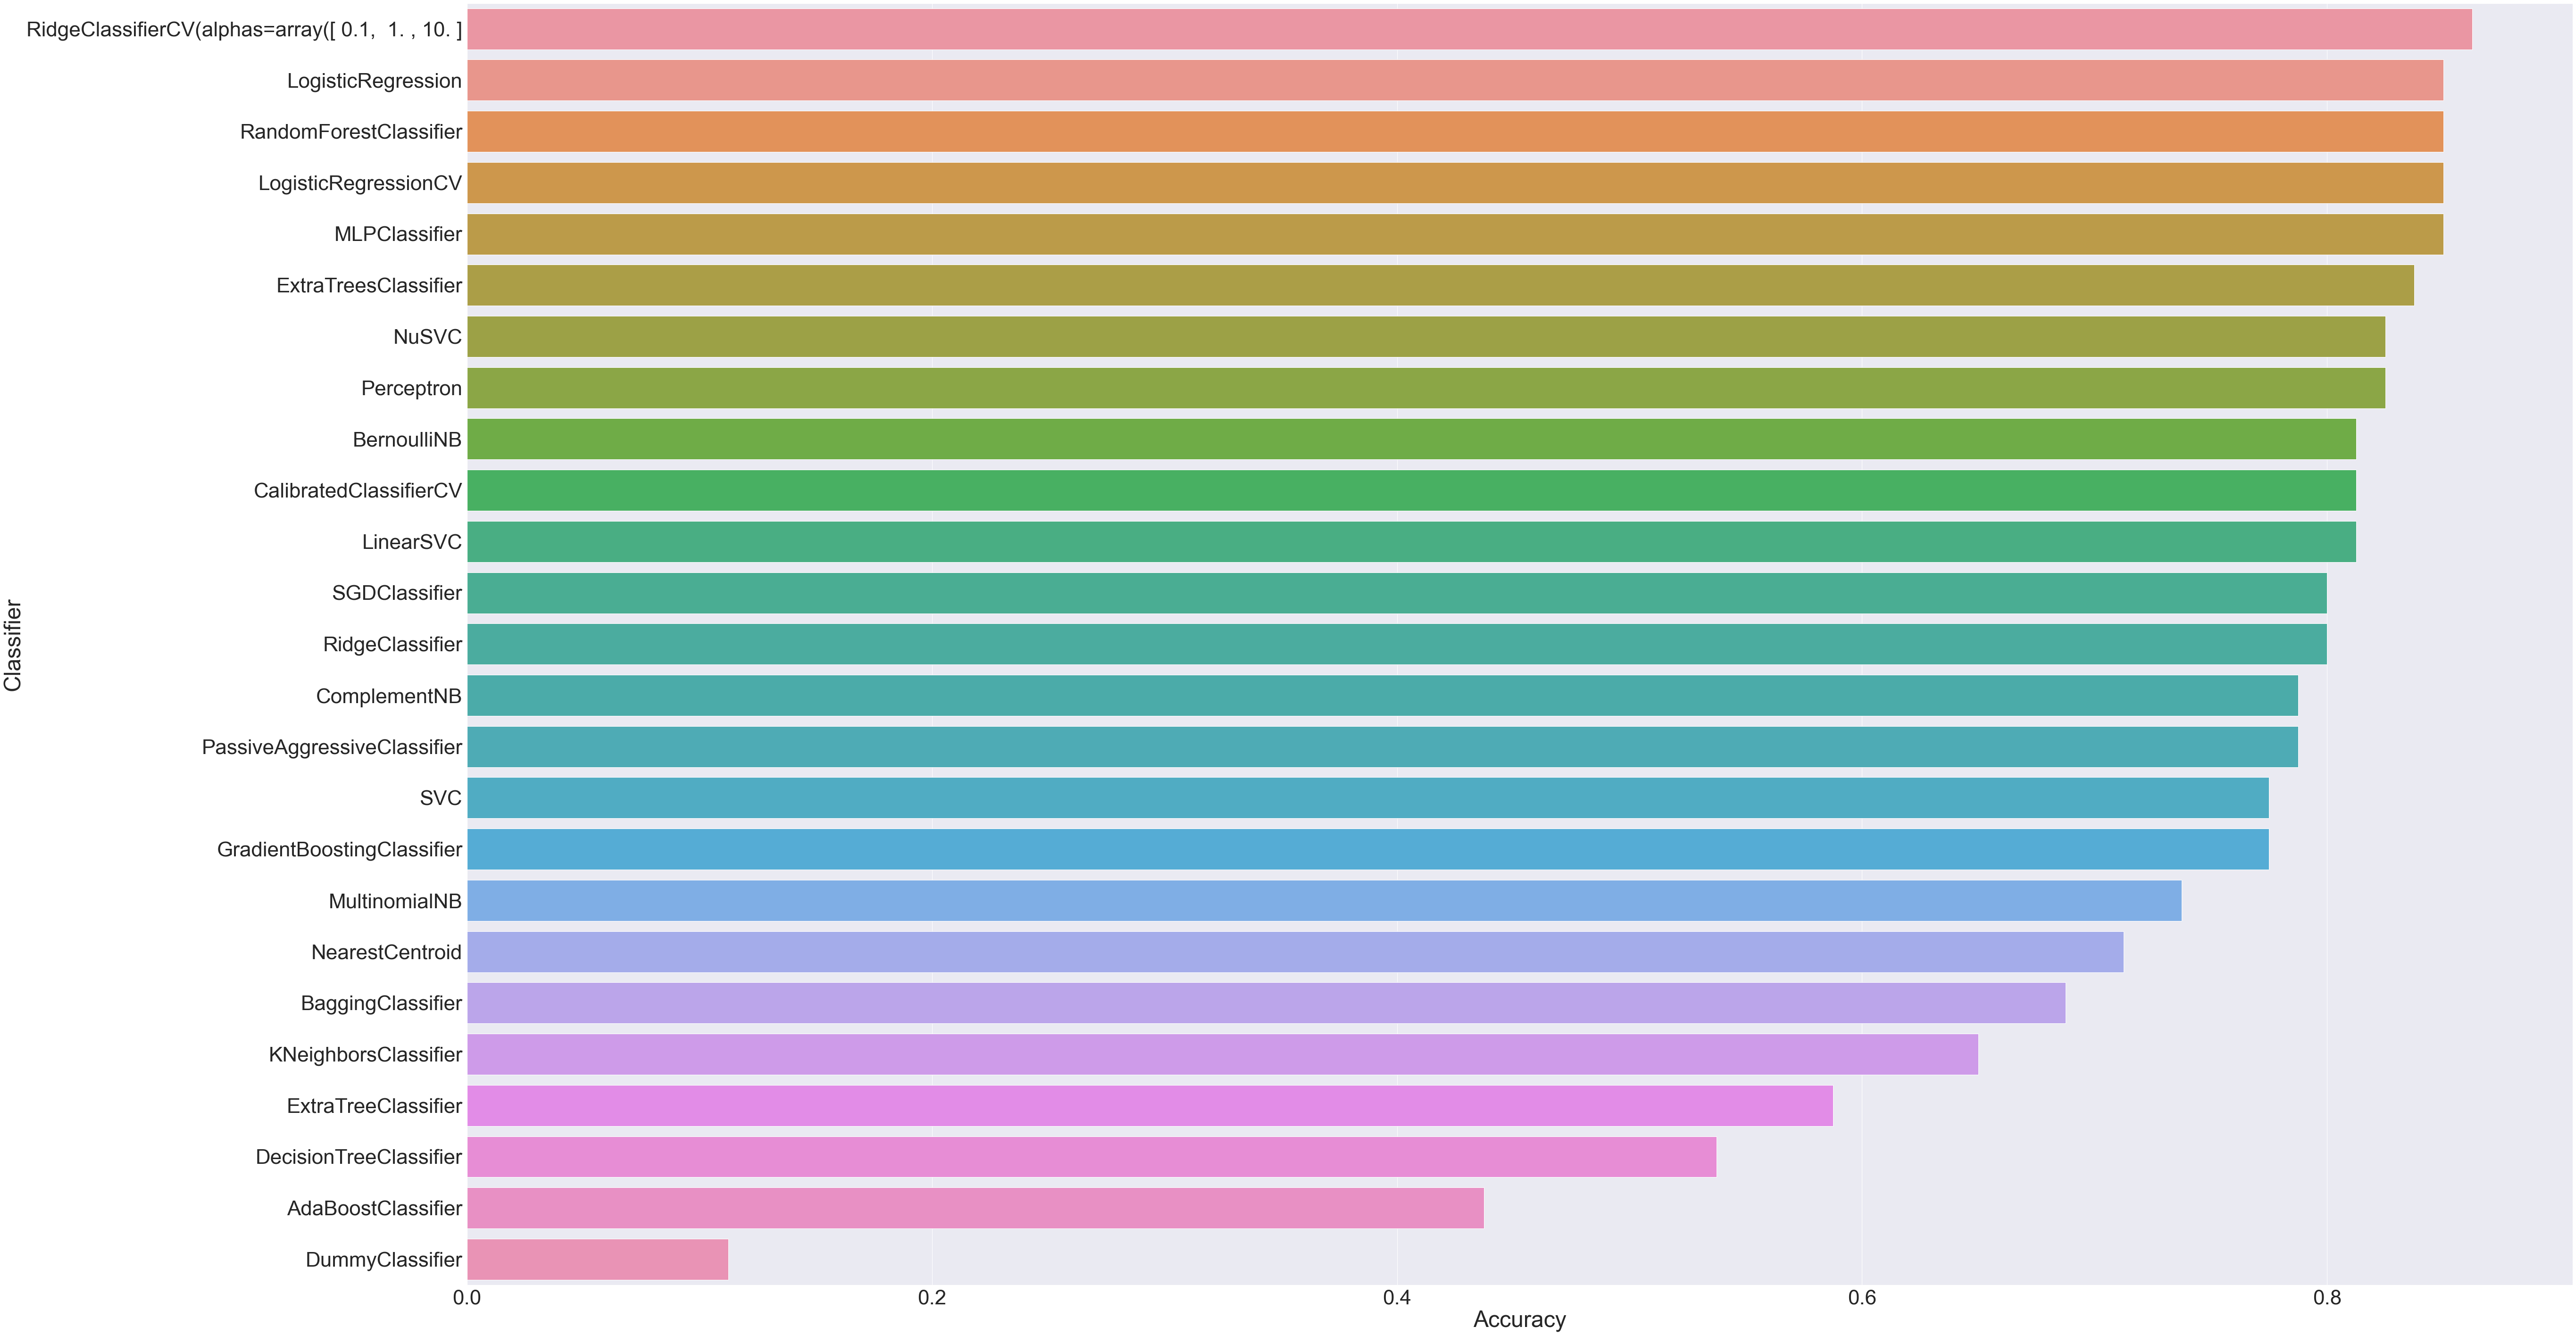

In [355]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
plt.legend([],[], frameon=False)
sns_t = sns.barplot(
    data=sorted_result_baseline, 
    x="Accuracy", y="Classifier", hue="Classifier",dodge=False
)

plt.legend([],[], frameon=False)

In [357]:
for name, clf in tqdm(zip(ok_names, ok_classifiers)):
    test_classifier_with_remove(clf,name)
    
result = pd.DataFrame(rows_list)

6it [00:36,  5.70s/it]/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/adrianawad/opt/

In [358]:
result.sample(25)

,Length of remove_list,Accuracy,Removed words,Classifier,Method
62,0,0.8250,[],Linear SVM,auto
1357,31,0.3000,"[tablespoon, cup, teaspoon, oil, pepper, garli...",Random Forest,auto
3024,18,0.7750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",SVC,auto
2547,31,0.8875,"[tablespoon, cup, teaspoon, oil, pepper, garli...",MLPClassifier,auto
371,61,0.7375,"[tablespoon, cup, teaspoon, oil, sauc, pepper,...",multinomial Naive Bayes,auto
790,0,0.7375,[],multinomial Naive Bayes,auto
2608,44,0.7375,"[tablespoon, cup, teaspoon, oil, pepper, garli...",MultinomialNB,auto
2159,77,0.1750,"[tablespoon, cup, teaspoon, oil, sauc, pepper,...",DummyClassifier,auto
2314,44,0.7750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",GradientBoostingClassifier,auto
3023,31,0.7750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",SVC,auto


<AxesSubplot:xlabel='Length of remove_list', ylabel='Accuracy'>

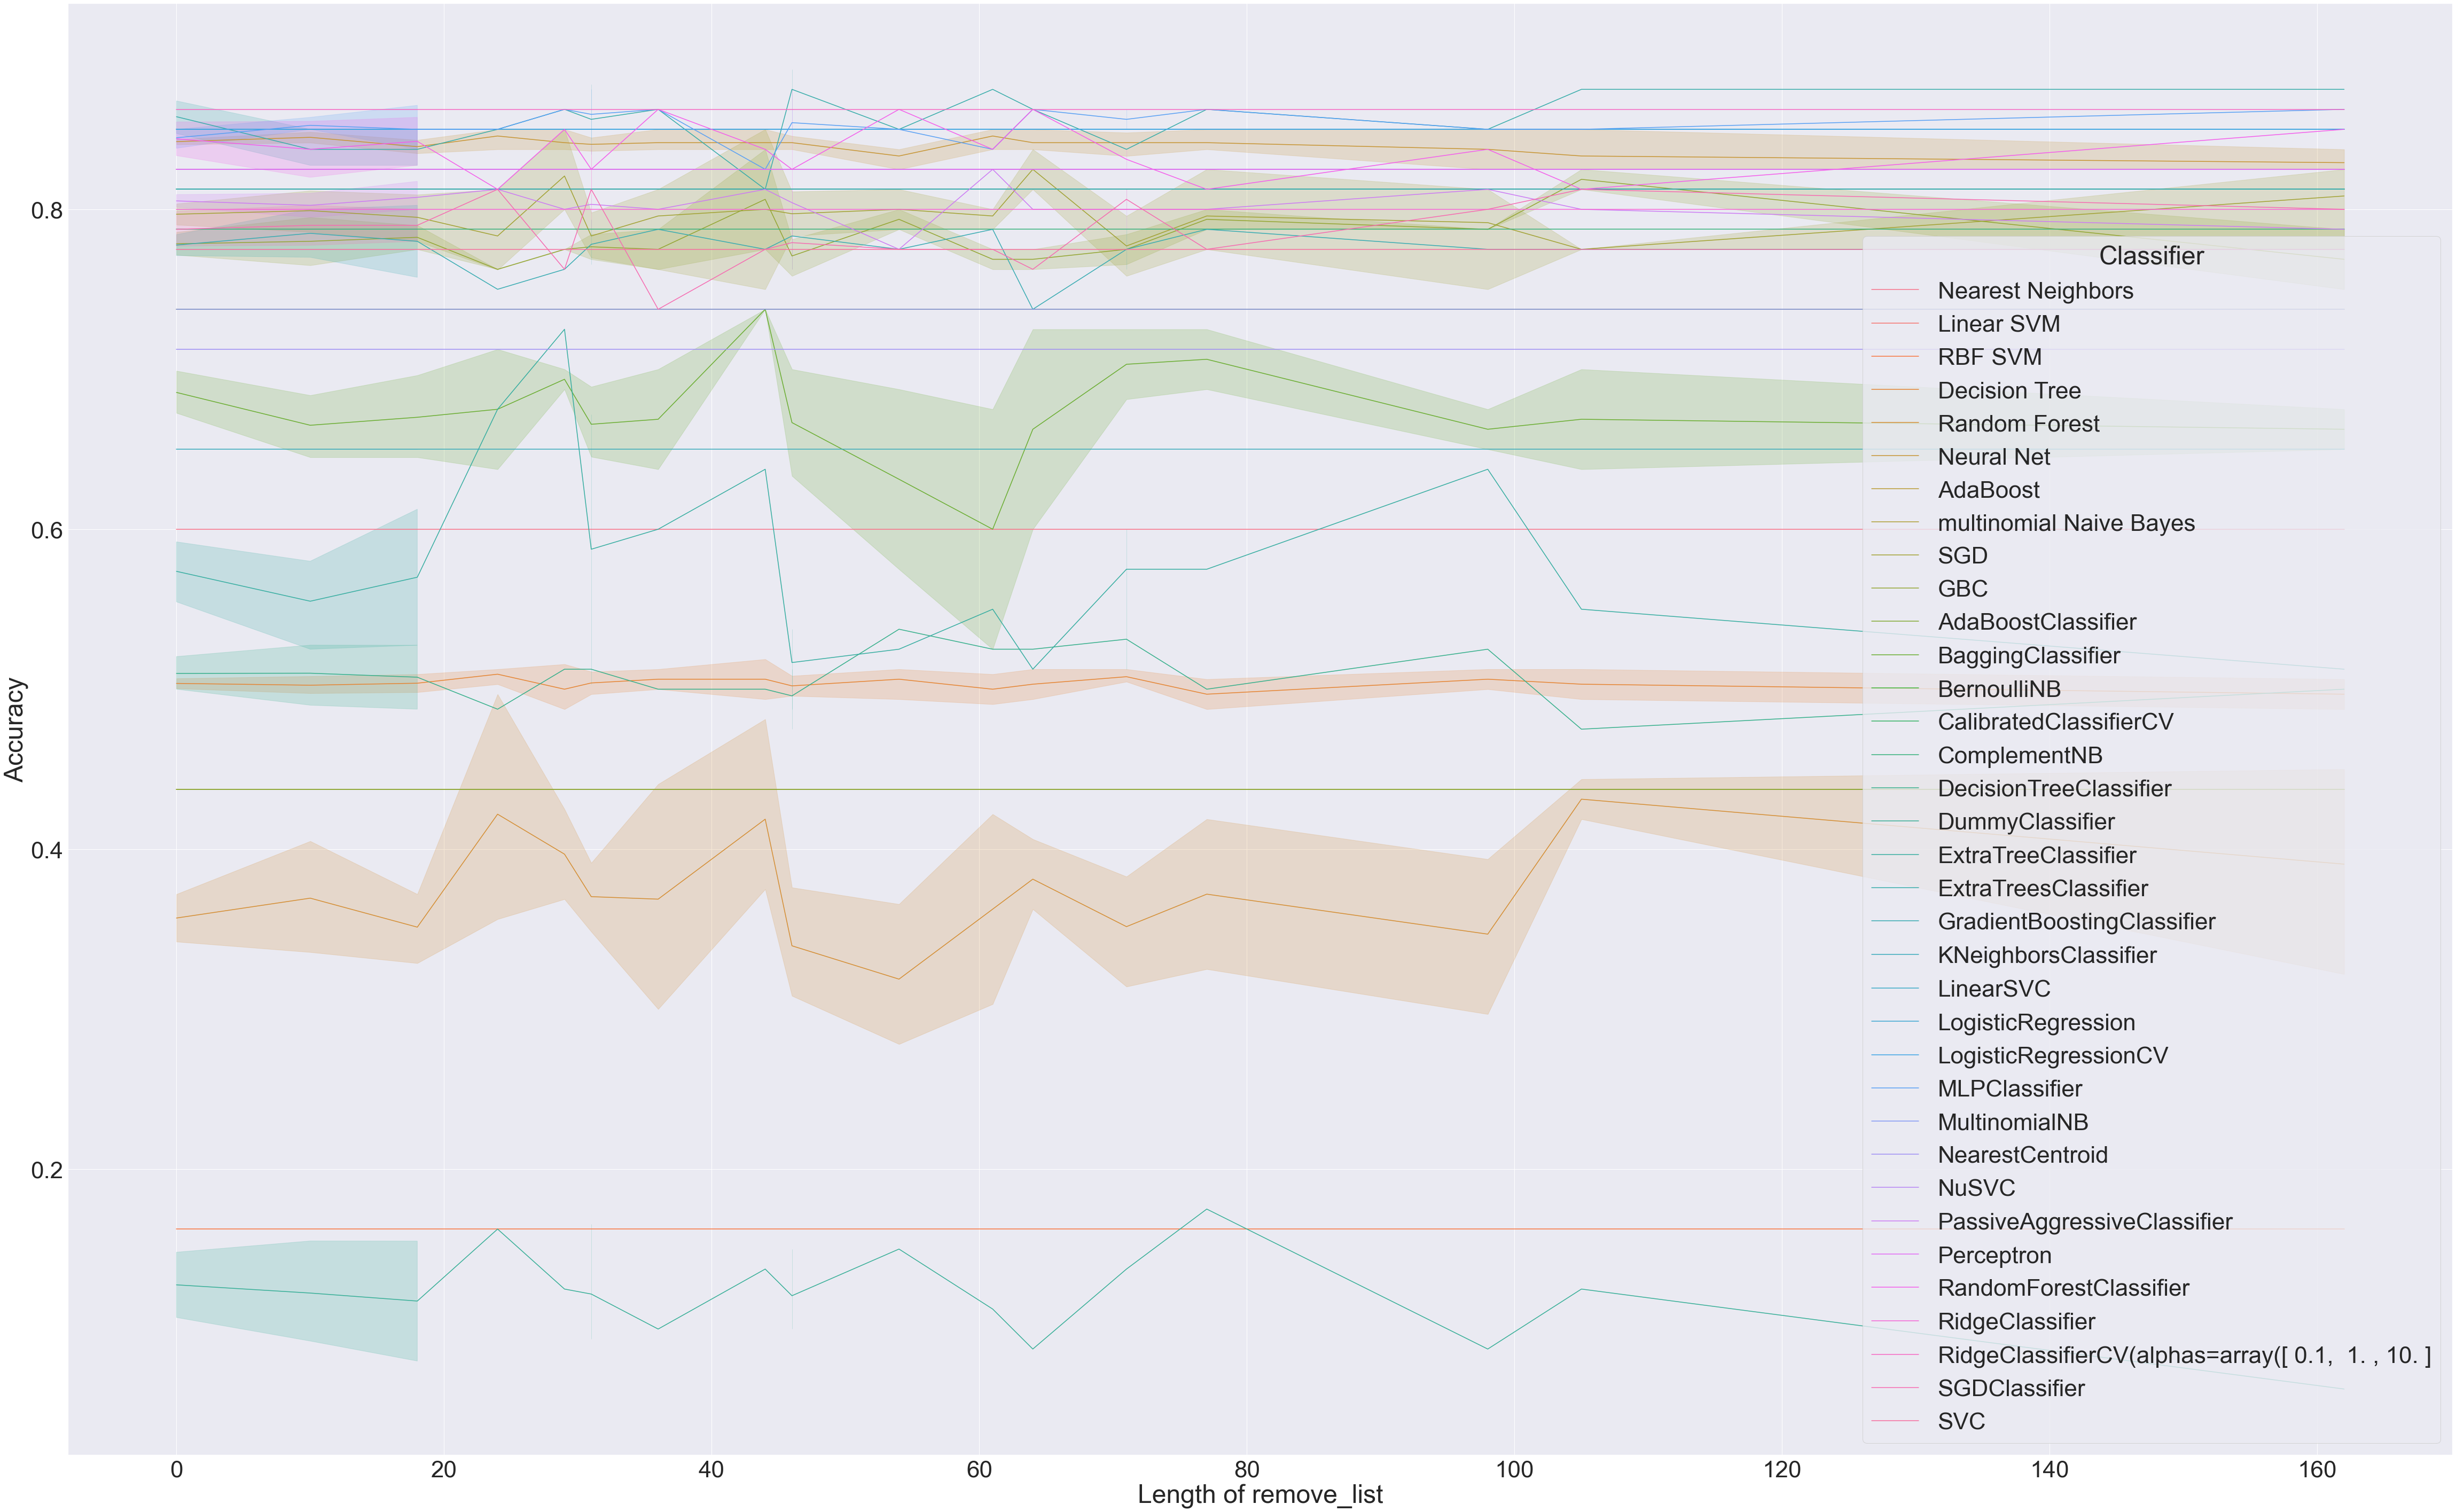

In [359]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
sns.lineplot(
    data=result, 
    x="Length of remove_list", y="Accuracy", hue="Classifier",
)

In [361]:
sorted_result= result.groupby('Classifier').agg({'Accuracy': 'max'}).reset_index()
sorted_result = sorted_result.sort_values(by=['Accuracy'], ascending=False)
sorted_result

,Classifier,Accuracy
10,ExtraTreesClassifier,0.9000
18,MLPClassifier,0.8875
28,RandomForestClassifier,0.8875
30,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]",0.8625
31,SGD,0.8625
17,LogisticRegressionCV,0.8500
16,LogisticRegression,0.8500
22,Neural Net,0.8500
32,SGDClassifier,0.8500
11,GBC,0.8375


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

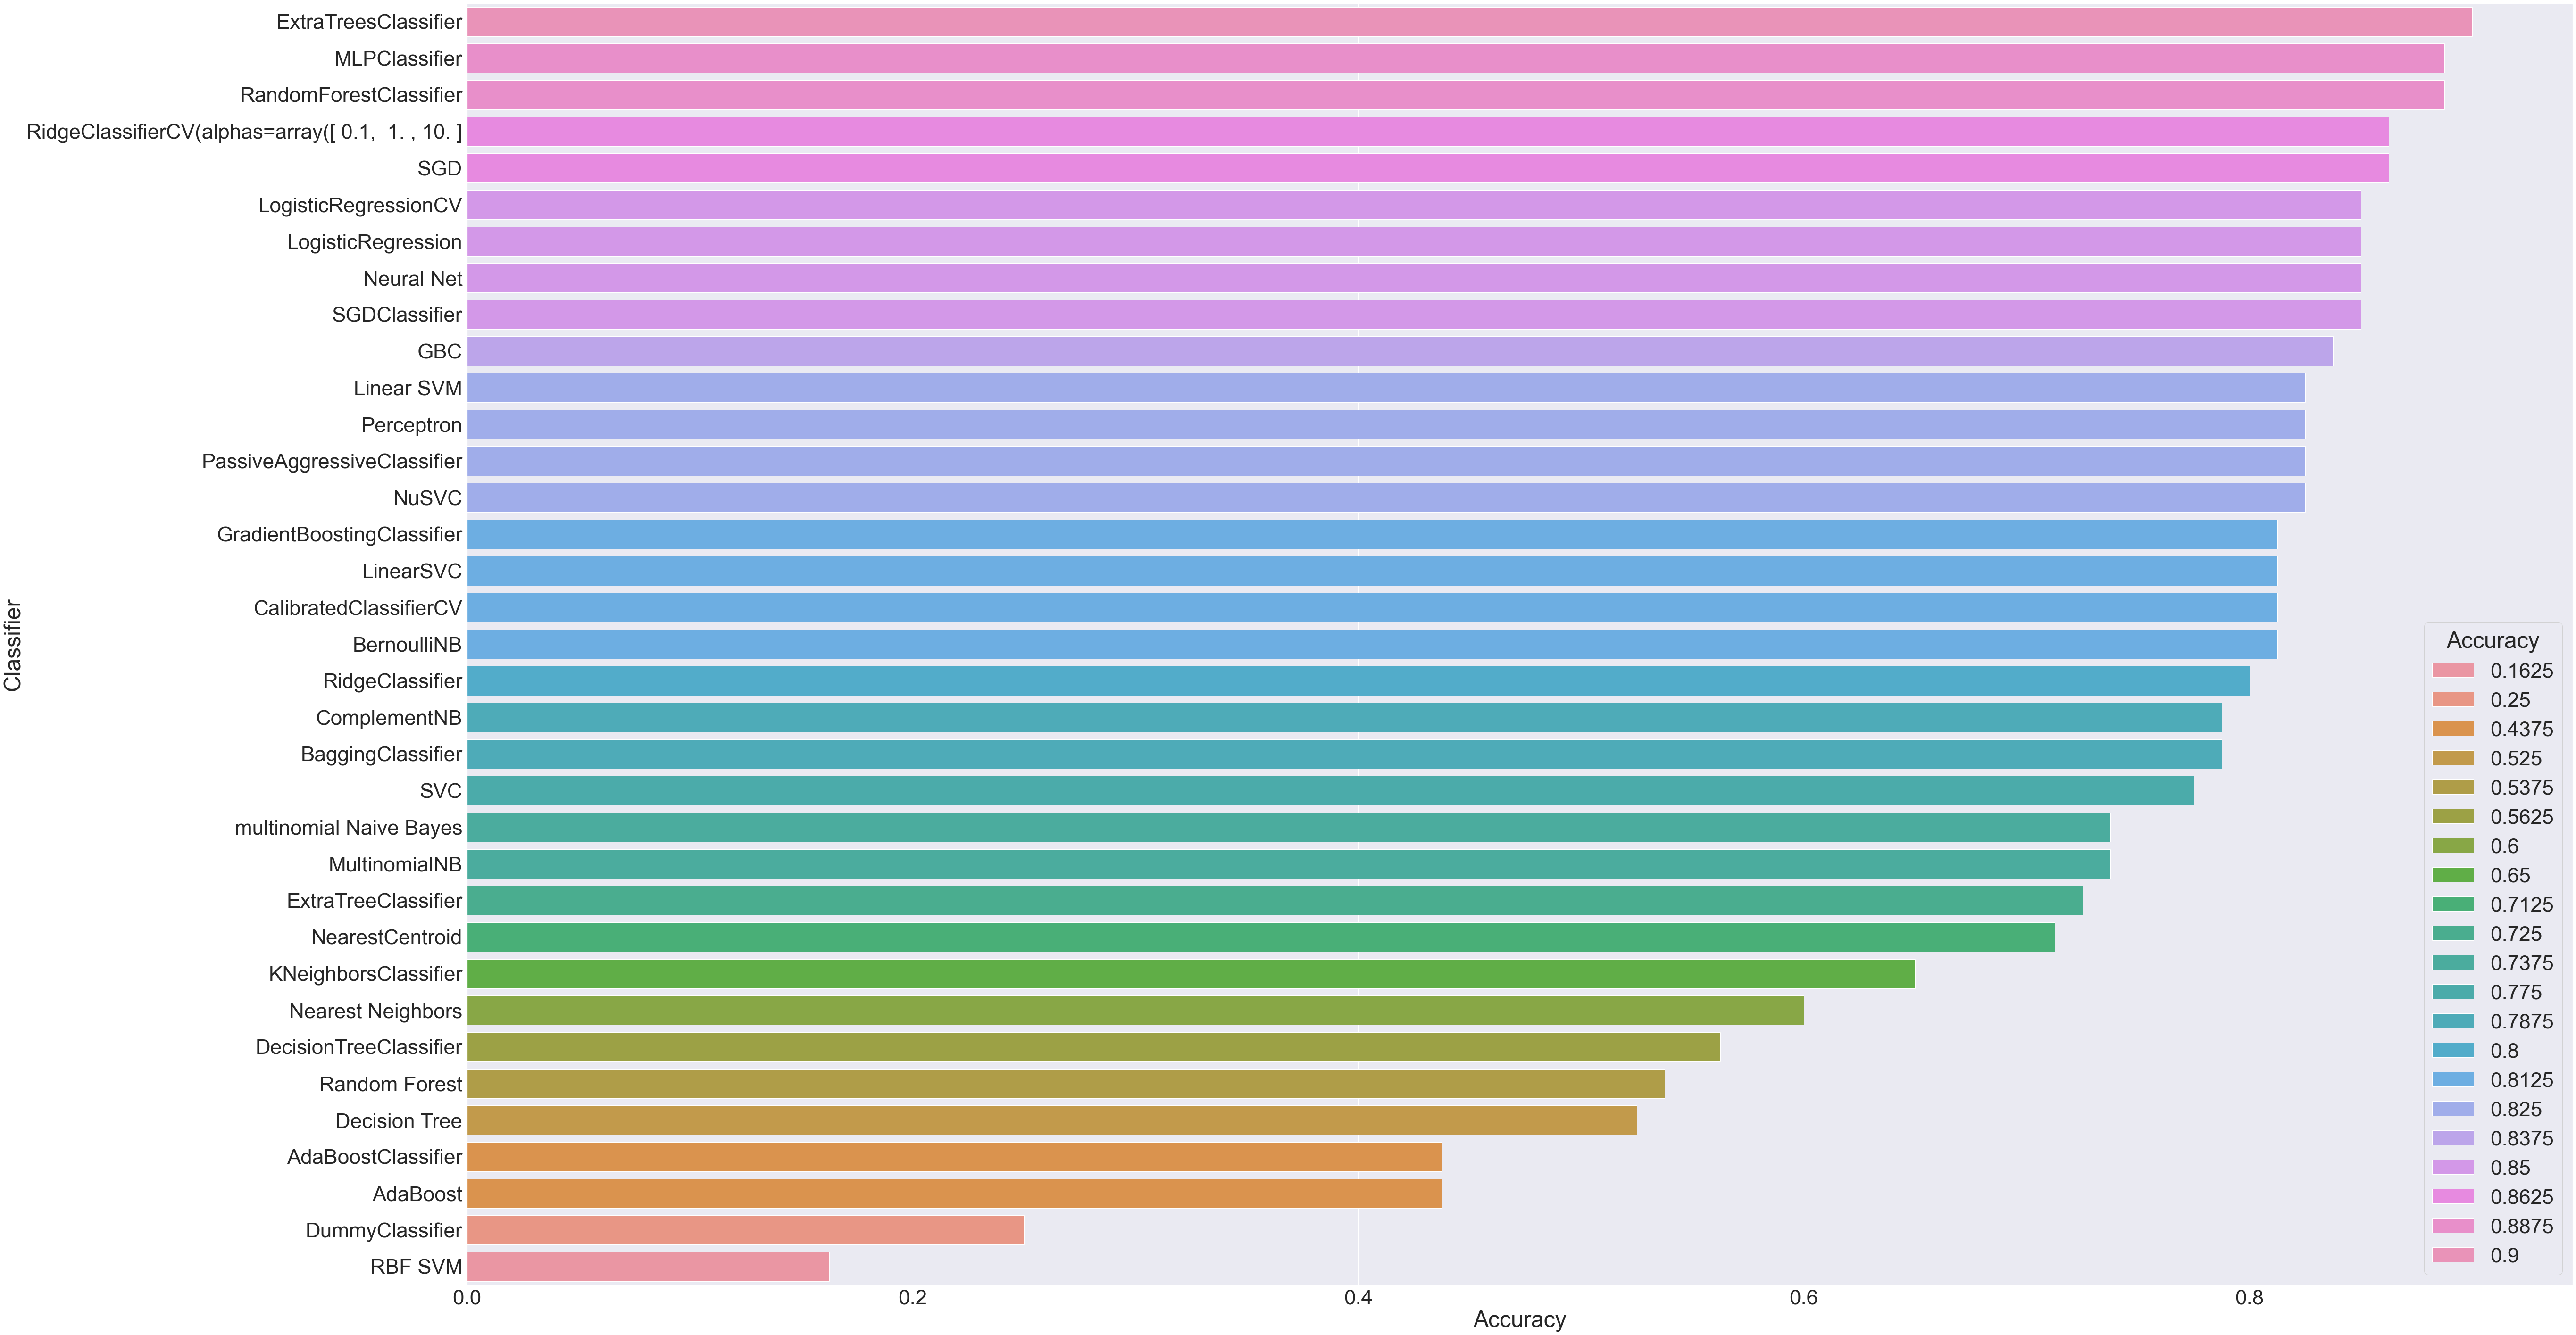

In [362]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=sorted_result, 
    x="Accuracy", y="Classifier", hue="Accuracy",dodge=False
)

In [366]:
tfidf_rows_list = []
X = train['cleanText']
Y = train['cuisine']
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=.2, 
                                                    random_state=8)


# iterate over classifiers
for name, clf in zip(ok_names, ok_classifiers):

    pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', clf),
              ])
    pipeline.fit(x_train, y_train)
    
    y_pred = pipeline.predict(x_test)
    score = accuracy_score(y_pred, y_test)

    dict1 = {
                "Classifier": name,
                "Accuracy": score,
                "Method": "tfidf"

            }
    tfidf_rows_list.append(dict1)
    
    
result_tfidf = pd.DataFrame(tfidf_rows_list)
result_tfidf = result_tfidf.sort_values(by=['Accuracy'], ascending=False)
result_tfidf

/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,Accuracy,Method
12,LogisticRegression,0.8750,tfidf
13,LogisticRegressionCV,0.8750,tfidf
22,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]",0.8625,tfidf
3,CalibratedClassifierCV,0.8625,tfidf
21,RidgeClassifier,0.8625,tfidf
8,ExtraTreesClassifier,0.8625,tfidf
11,LinearSVC,0.8500,tfidf
17,NuSVC,0.8500,tfidf
14,MLPClassifier,0.8500,tfidf
24,SVC,0.8500,tfidf


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

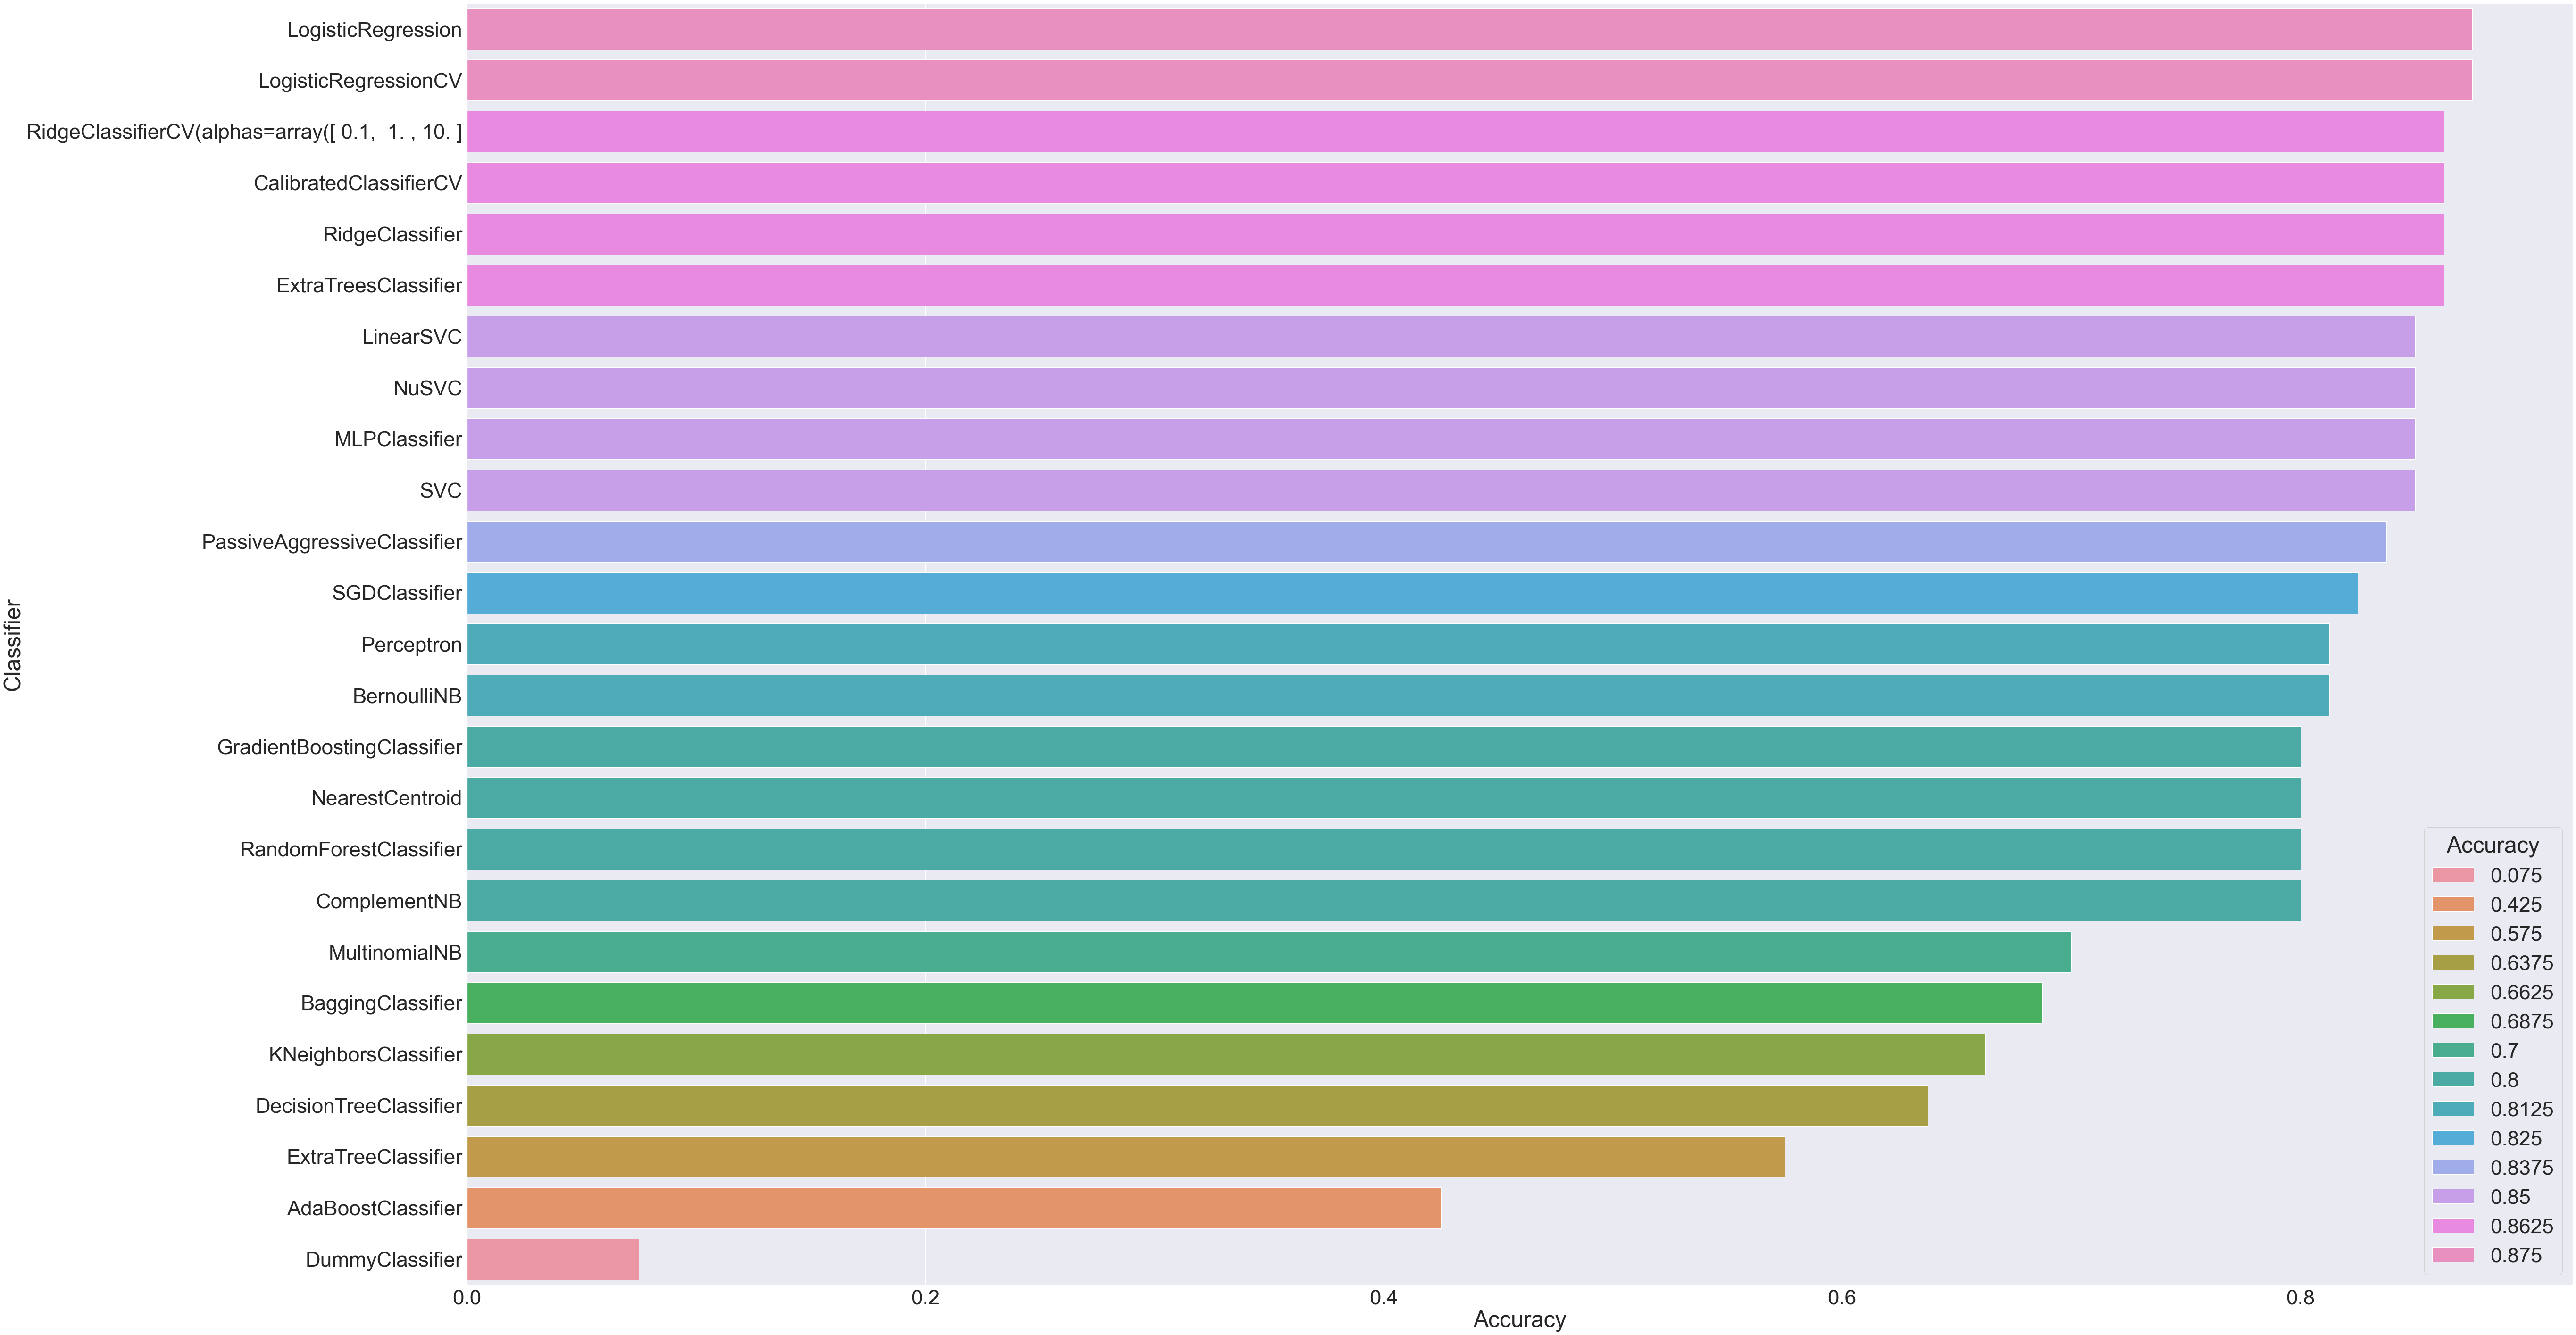

In [367]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=result_tfidf, 
    x="Accuracy", y="Classifier", hue="Accuracy",dodge=False
)

In [368]:
all_classifier_combinations = sorted_result.append(result_tfidf, sort=False)

all_classifier_combinations['Method'] = all_classifier_combinations['Method'].fillna("auto")

all_classifier_combinations

,Classifier,Accuracy,Method
10,ExtraTreesClassifier,0.9000,auto
18,MLPClassifier,0.8875,auto
28,RandomForestClassifier,0.8875,auto
30,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]",0.8625,auto
31,SGD,0.8625,auto
17,LogisticRegressionCV,0.8500,auto
16,LogisticRegression,0.8500,auto
22,Neural Net,0.8500,auto
32,SGDClassifier,0.8500,auto
11,GBC,0.8375,auto


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

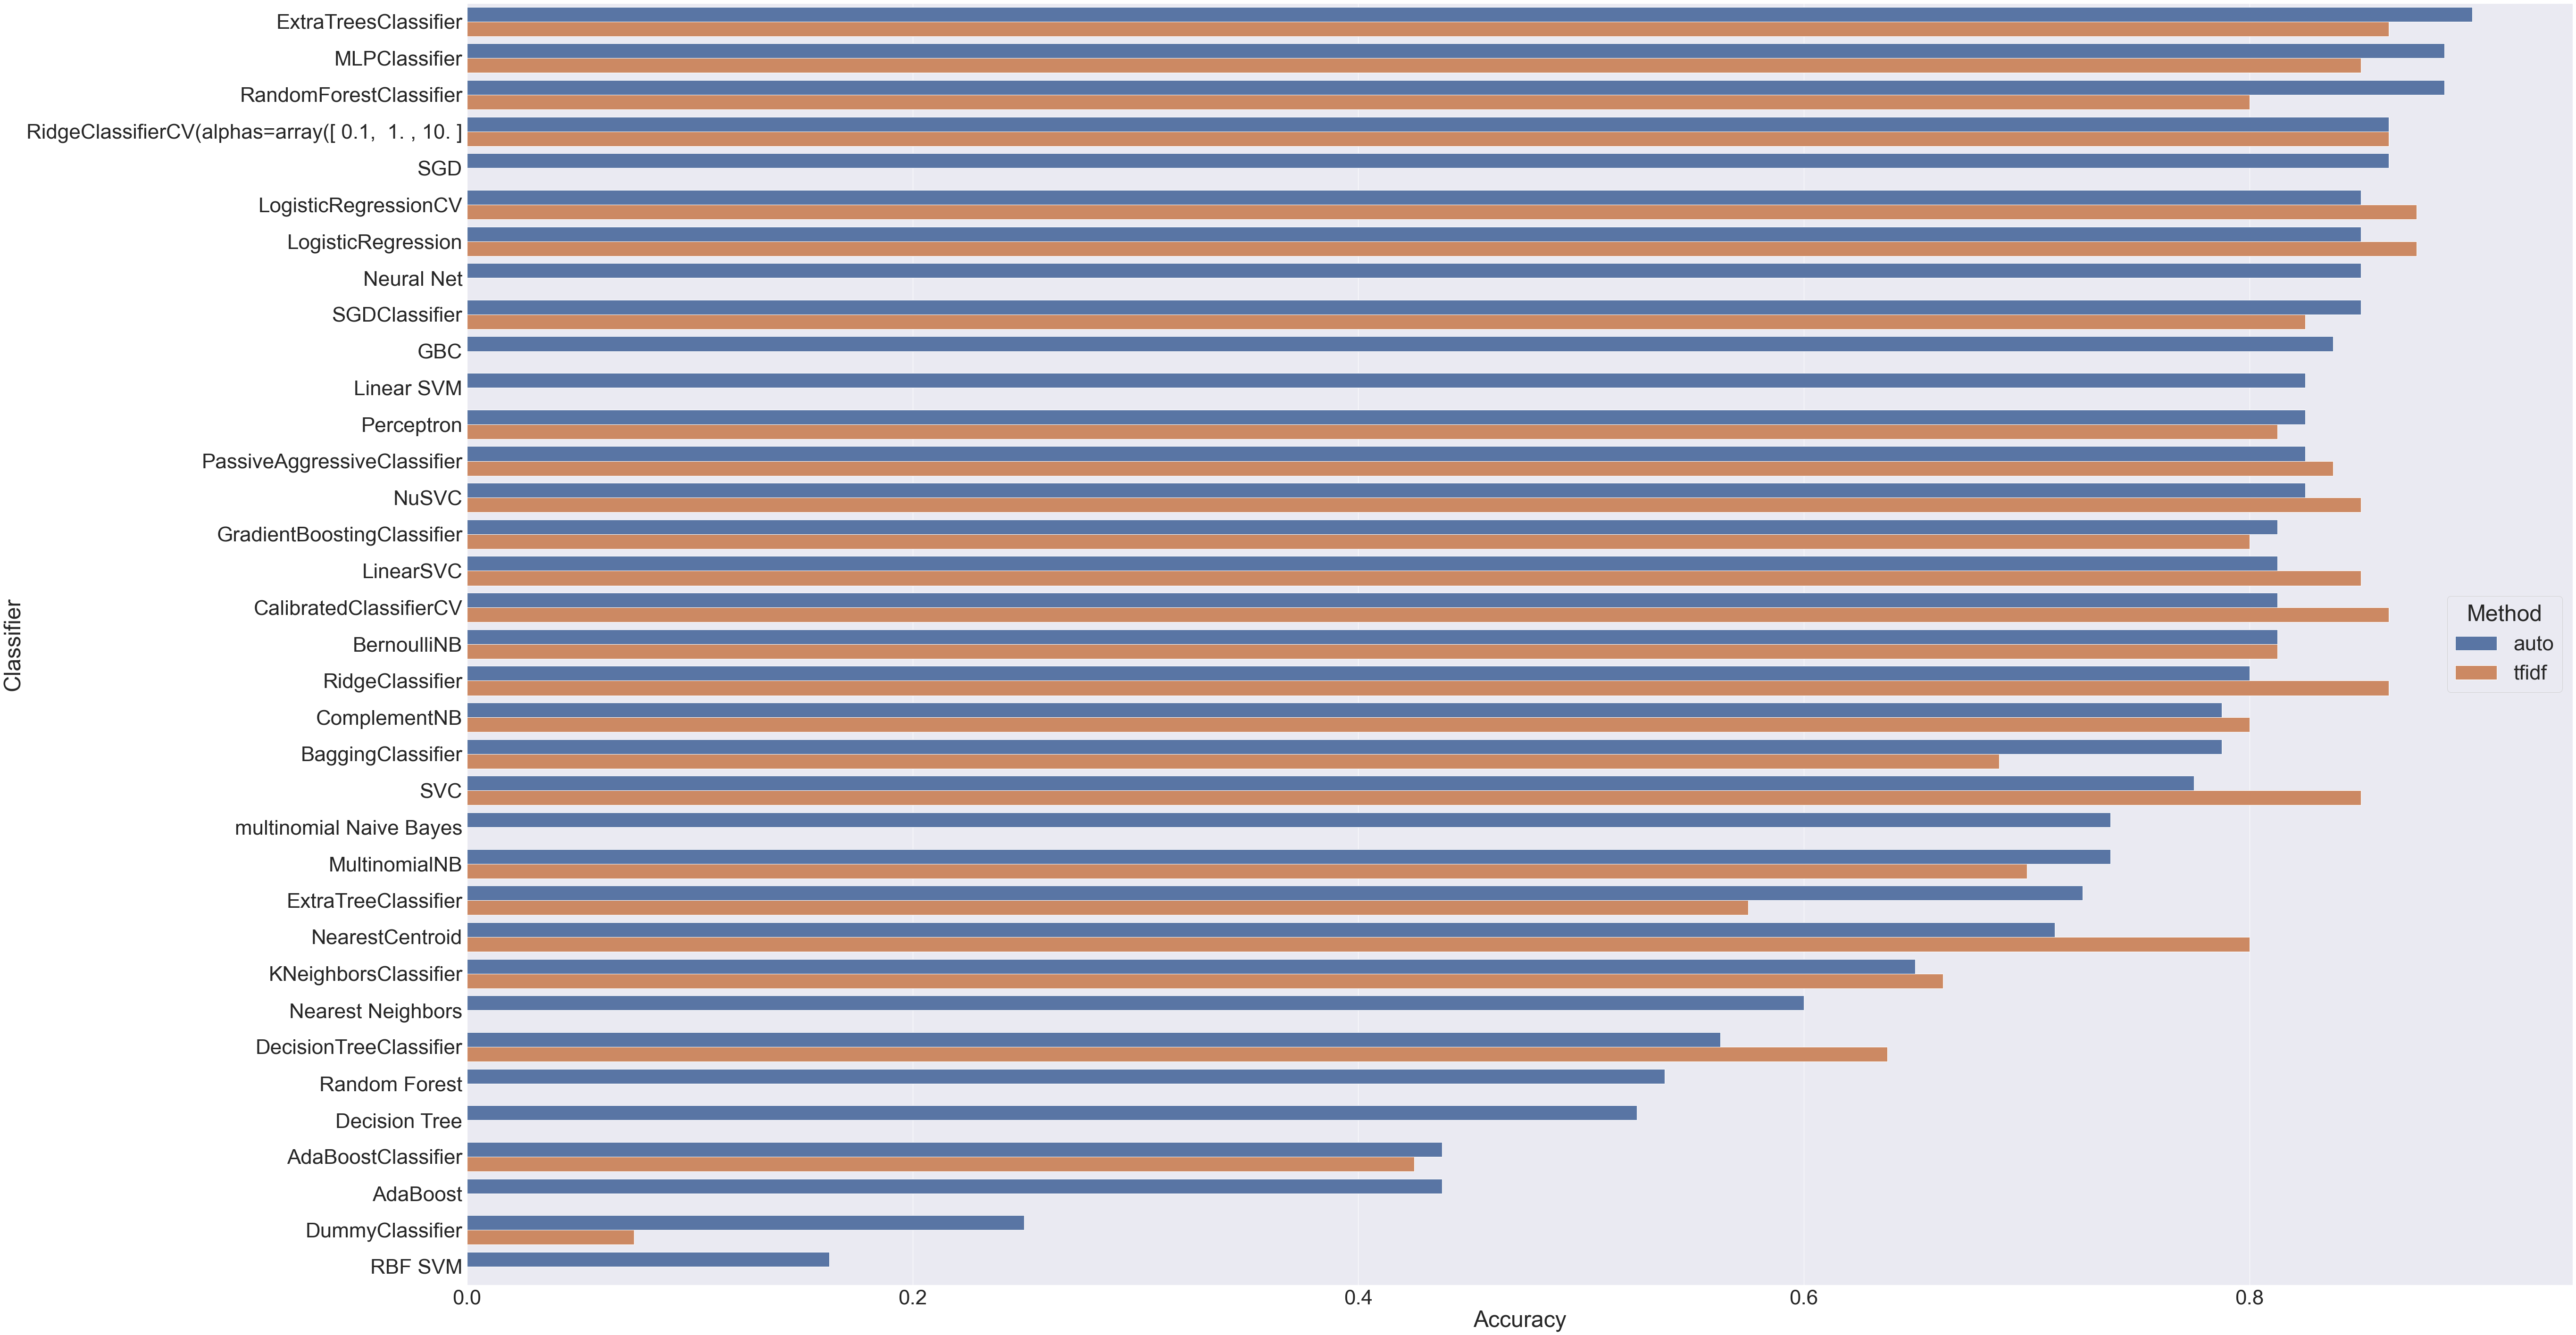

In [373]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=all_classifier_combinations, 
    x="Accuracy", y="Classifier", hue="Method"
)

In [371]:
for method in ["auto", "tfidf"]:
    best = all_classifier_combinations.loc[all_classifier_combinations["Method"] == method]
    best = best.loc[best["Accuracy"] >= 0.85]
    mean = all_classifier_combinations.loc[all_classifier_combinations["Method"] == method]
    mean = mean["Accuracy"].mean()
    print("Method: " + method)
    print(best)
    print( "Mean of Method: " + str(mean))
    print()

Method: auto
                                           Classifier  Accuracy Method
10                               ExtraTreesClassifier    0.9000   auto
18                                      MLPClassifier    0.8875   auto
28                             RandomForestClassifier    0.8875   auto
30  RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]    0.8625   auto
31                                                SGD    0.8625   auto
17                               LogisticRegressionCV    0.8500   auto
16                                 LogisticRegression    0.8500   auto
22                                         Neural Net    0.8500   auto
32                                      SGDClassifier    0.8500   auto
Mean of Method: 0.7260714285714285

Method: tfidf
                                           Classifier  Accuracy Method
12                                 LogisticRegression    0.8750  tfidf
13                               LogisticRegressionCV    0.8750  tfidf
22  RidgeClass

In [21]:
test_final = test_final.sample(frac=1).reset_index(drop=True)

X_test = test_final["cleanText"]
Y_test = test_final["cuisine"]

print(classifiers)

[AdaBoostClassifier(), BaggingClassifier(), BernoulliNB(), CalibratedClassifierCV(), CategoricalNB(), ComplementNB(), DecisionTreeClassifier(), DummyClassifier(), ExtraTreeClassifier(), ExtraTreesClassifier(), GaussianNB(), GaussianProcessClassifier(), GradientBoostingClassifier(), HistGradientBoostingClassifier(), KNeighborsClassifier(), LabelPropagation(), LabelSpreading(), LinearDiscriminantAnalysis(), LinearSVC(), LogisticRegression(), LogisticRegressionCV(), MLPClassifier(), MultinomialNB(), NearestCentroid(), NuSVC(), PassiveAggressiveClassifier(), Perceptron(), QuadraticDiscriminantAnalysis(), RadiusNeighborsClassifier(), RandomForestClassifier(), RidgeClassifier(), RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])), SGDClassifier(), SVC()]


In [22]:
from sklearn. linear_model import LogisticRegression

logistic_regression = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
logistic_regression.fit(train["cleanText"], train["cuisine"])

y_pred = logistic_regression.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred))

accuracy 0.75
              precision    recall  f1-score   support

     Chinese       0.80      0.80      0.80         5
       Greek       0.83      1.00      0.91         5
      Iberic       0.71      1.00      0.83         5
     Italian       0.80      0.80      0.80         5
        Thai       1.00      0.40      0.57         5
  Vietnamese       0.67      0.80      0.73         5
      french       0.50      0.60      0.55         5
      korean       1.00      0.60      0.75         5

    accuracy                           0.75        40
   macro avg       0.79      0.75      0.74        40
weighted avg       0.79      0.75      0.74        40



In [30]:
logistic_regression.steps[2][1].coef_

array([[-0.09905402, -0.01702982, -0.03052542, ...,  0.13257895,
        -0.1604309 , -0.03298656],
       [-0.05548797, -0.00528574,  0.13677118, ...,  0.54213493,
        -0.05423833, -0.01564766],
       [ 0.63572948, -0.00736986, -0.08905902, ..., -0.28139293,
        -0.23081031, -0.02595356],
       ...,
       [-0.07323589, -0.01734396, -0.04417793, ..., -0.06446108,
        -0.04299119, -0.02825448],
       [-0.15410986, -0.00662007,  0.1546029 , ..., -0.02682299,
         0.38252401, -0.0228025 ],
       [-0.07144894,  0.08084162, -0.02841435, ..., -0.15158397,
         0.22489881, -0.01608756]])

In [69]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

data = train


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
# max combinations: 3x4x2x2x2x4x2x2= 1536
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1, 10, 100, 1000),
    'clf__gamma': (0.001, 0.0001,1, 2),
    'clf__kernel': ('linear', 'rbf'), 
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.cleanText, data.cuisine)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (1, 10, 100, 1000),
 'clf__gamma': (0.001, 0.0001, 1, 2),
 'clf__kernel': ('linear', 'rbf'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  4.3min


done in 308.862s

Best score: 0.825
Best parameters set:
	clf__C: 10
	clf__gamma: 1
	clf__kernel: 'rbf'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: None
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed:  5.1min finished
